# Analyze Nanostring data

Use Squidpy and Scanpy for the analysis of Nanostring data.

In [30]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq

sc.logging.print_header()

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.3 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.11.3 louvain==0.8.1 pynndescent==0.5.11


## Download the data, unpack and load to AnnData

Download the data from [Nanostring FFPE Dataset](https://nanostring.com/products/cosmx-spatial-molecular-imager/ffpe-dataset/nsclc-ffpe-dataset/). Unpack the `tar.gz` file and load the unpacked dataset into an `anndata.AnnData` object. The dataset consists of a non-small-cell lung cancer (NSCLC) tissue which represents the largest single-cell and sub-cellular analysis on Formalin-Fixed Paraffin-Embedded (FFPE) samples.

In [31]:
# had to delete lines with fov > 30 in "Lung5_Rep2_fov_positions_file.csv" file to get this to work
nanostring_dir = Path().resolve() / "data" / "nanostring_data"
sample_dir = nanostring_dir / "Lung5_Rep2" / "Lung5_Rep2-Flat_files_and_images"

adata = sq.read.nanostring(
    path=sample_dir,
    counts_file="Lung5_Rep2_exprMat_file.csv",
    meta_file="Lung5_Rep2_metadata_file.csv",
    fov_file="Lung5_Rep2_fov_positions_file.csv",
)

## Calculate QC metrics

Obtain the control probes using their names prefixed with "NegPrb-". Calculate the QC metrics on the `adddata.AnnData` using `scanpy.pp.calculate_qc_metrics`. 

In [32]:
adata.var["NegPrb"] = adata.var_names.str.startswith("NegPrb")
sc.pp.calculate_qc_metrics(adata, qc_vars=["NegPrb"], inplace=True)

In [33]:
import pandas as pd

pd.set_option("display.max_columns", None)

The percentage of unassigned "NegPrb" transcripts can be calculated from the calulated qc metrics. This can later be used to estimate false discovery rate.

In [34]:
adata.obs["total_counts_NegPrb"].sum() / adata.obs["total_counts"].sum() * 100

0.3722155201830987

Next, plot the distribution of the total transcripts per cell, unique transcripts per cell and transcripts per FOV.

<Axes: title={'center': 'Transcripts per FOV'}, xlabel='total_counts', ylabel='Count'>

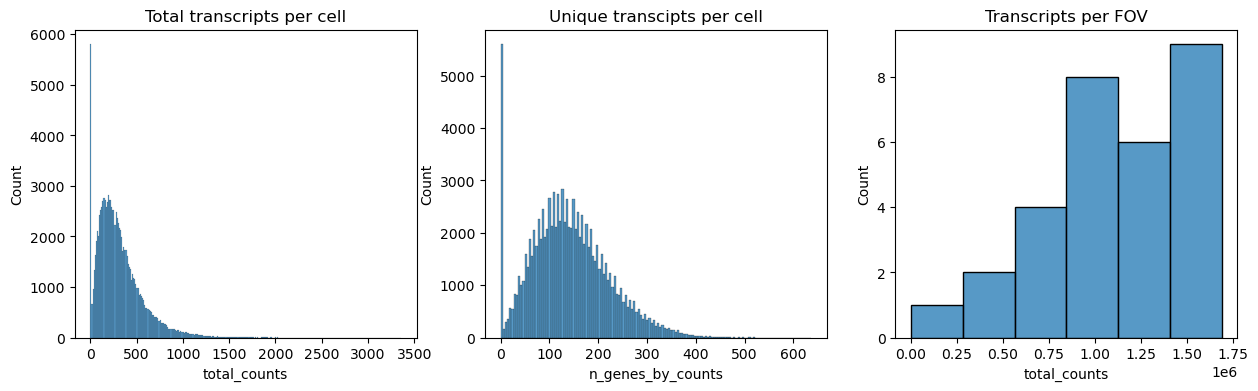

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcipts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)

axs[2].set_title("Transcripts per FOV")
sns.histplot(
    adata.obs.groupby("fov").sum()["total_counts"],
    kde=False,
    ax=axs[2],
)

The dataset also contains immunofluorescence data, it can be read from adata.obs

<Axes: title={'center': 'CD3'}, xlabel='Mean.CD3', ylabel='Count'>

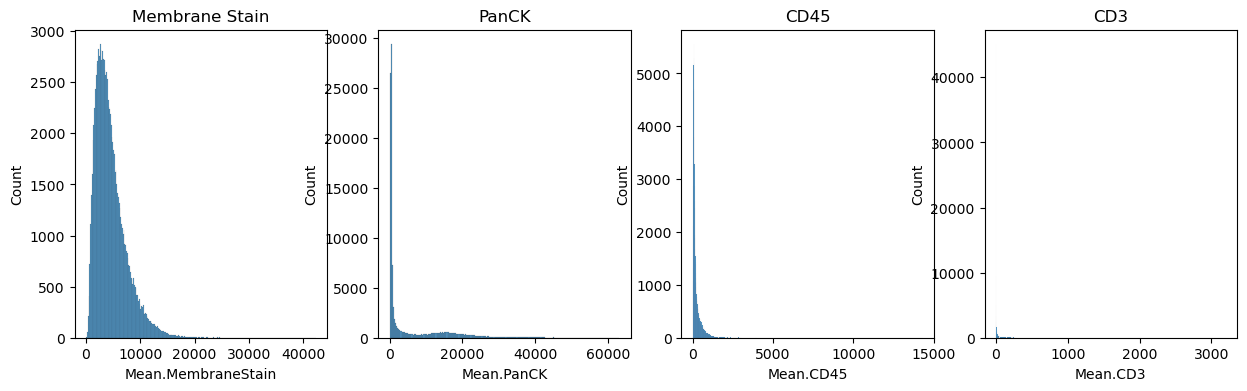

In [36]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Membrane Stain")
sns.histplot(
    adata.obs["Mean.MembraneStain"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("PanCK")
sns.histplot(
    adata.obs["Mean.PanCK"],
    kde=False,
    ax=axs[1],
)

axs[2].set_title("CD45")
sns.histplot(
    adata.obs["Mean.CD45"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("CD3")
sns.histplot(
    adata.obs["Mean.CD3"],
    kde=False,
    ax=axs[3],
)

Filter the cells based on the min number of counts required using `scanpy.pp.filter_cells`. Filter the genes based on the min number of cells required with `scanpy.pp.filter_genes`. These parameters were specified based on the plots above. This filtering is quite conservative.

In [37]:
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=400)

Normalize the counts per cell using `scanpy.pp.normalize_total`.

Logarithmize : `scanpy.pp.log1p`
PCA : `scanpy.pp.pca`
Compute neighborhood graph: `scanpy.pp.neighbors`

Use `scanpy.tl.umap` to embed the neighborhood graph of the data and cluster the cells into subgroups employing `scanpy.tl.leiden`.

In [38]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

## Visualize annotation on UMAP and spatial coordinates

Subplot with scatter plot in UMAP basis. The embedded points were colored, respectively, according to the total counts, number of genes by counts and leiden clusters in each of the subplots.

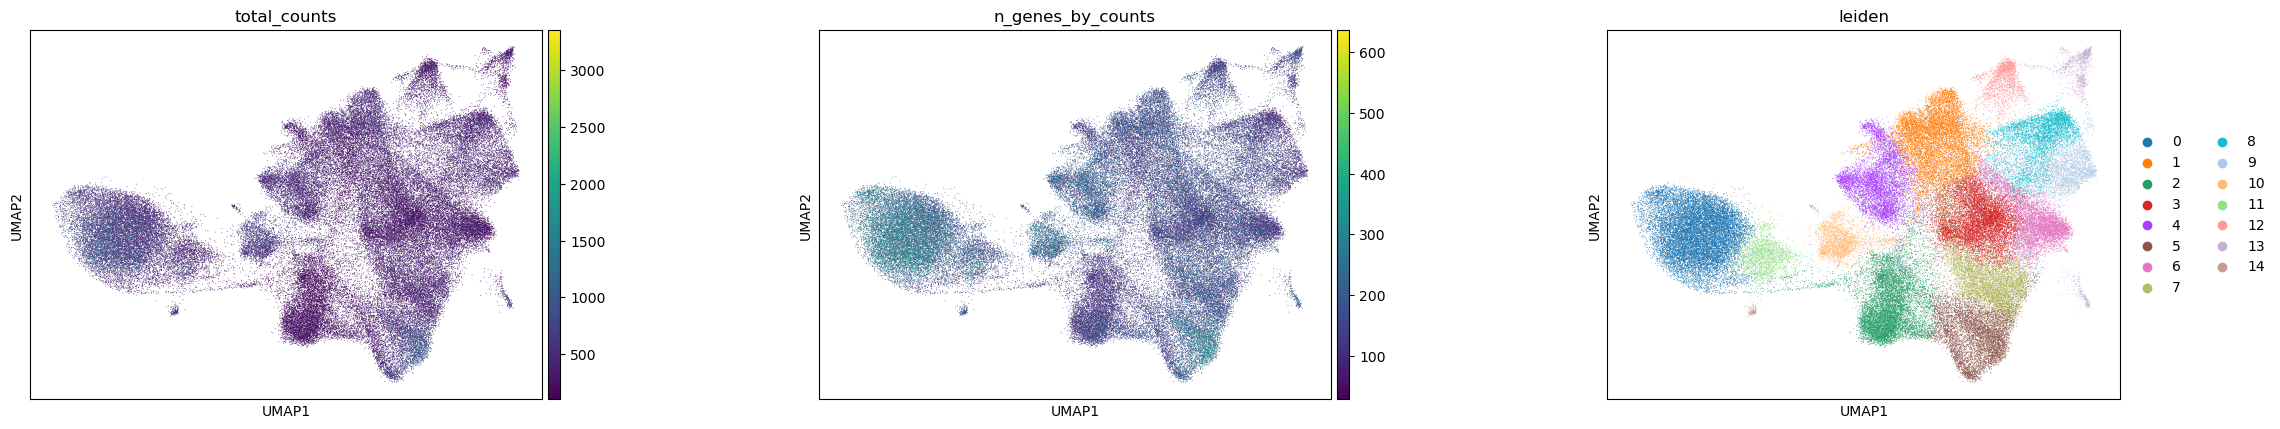

In [39]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4
)

Plot segmentation masks using `squidpy.pl.spatial_segment`. Specifically, the key `library_id` in `adata.obs` contains the same unique values contained in `adata.obs["spatial"]`. The `"cell_ID"` column is used to spot individual cells. Here, the images were colored in accordance with the intensity of the max pan-cytokeratin (CK) staining.

TypeError: 'collection' must be an instance of matplotlib.collections.Collection, not a matplotlib.image.AxesImage

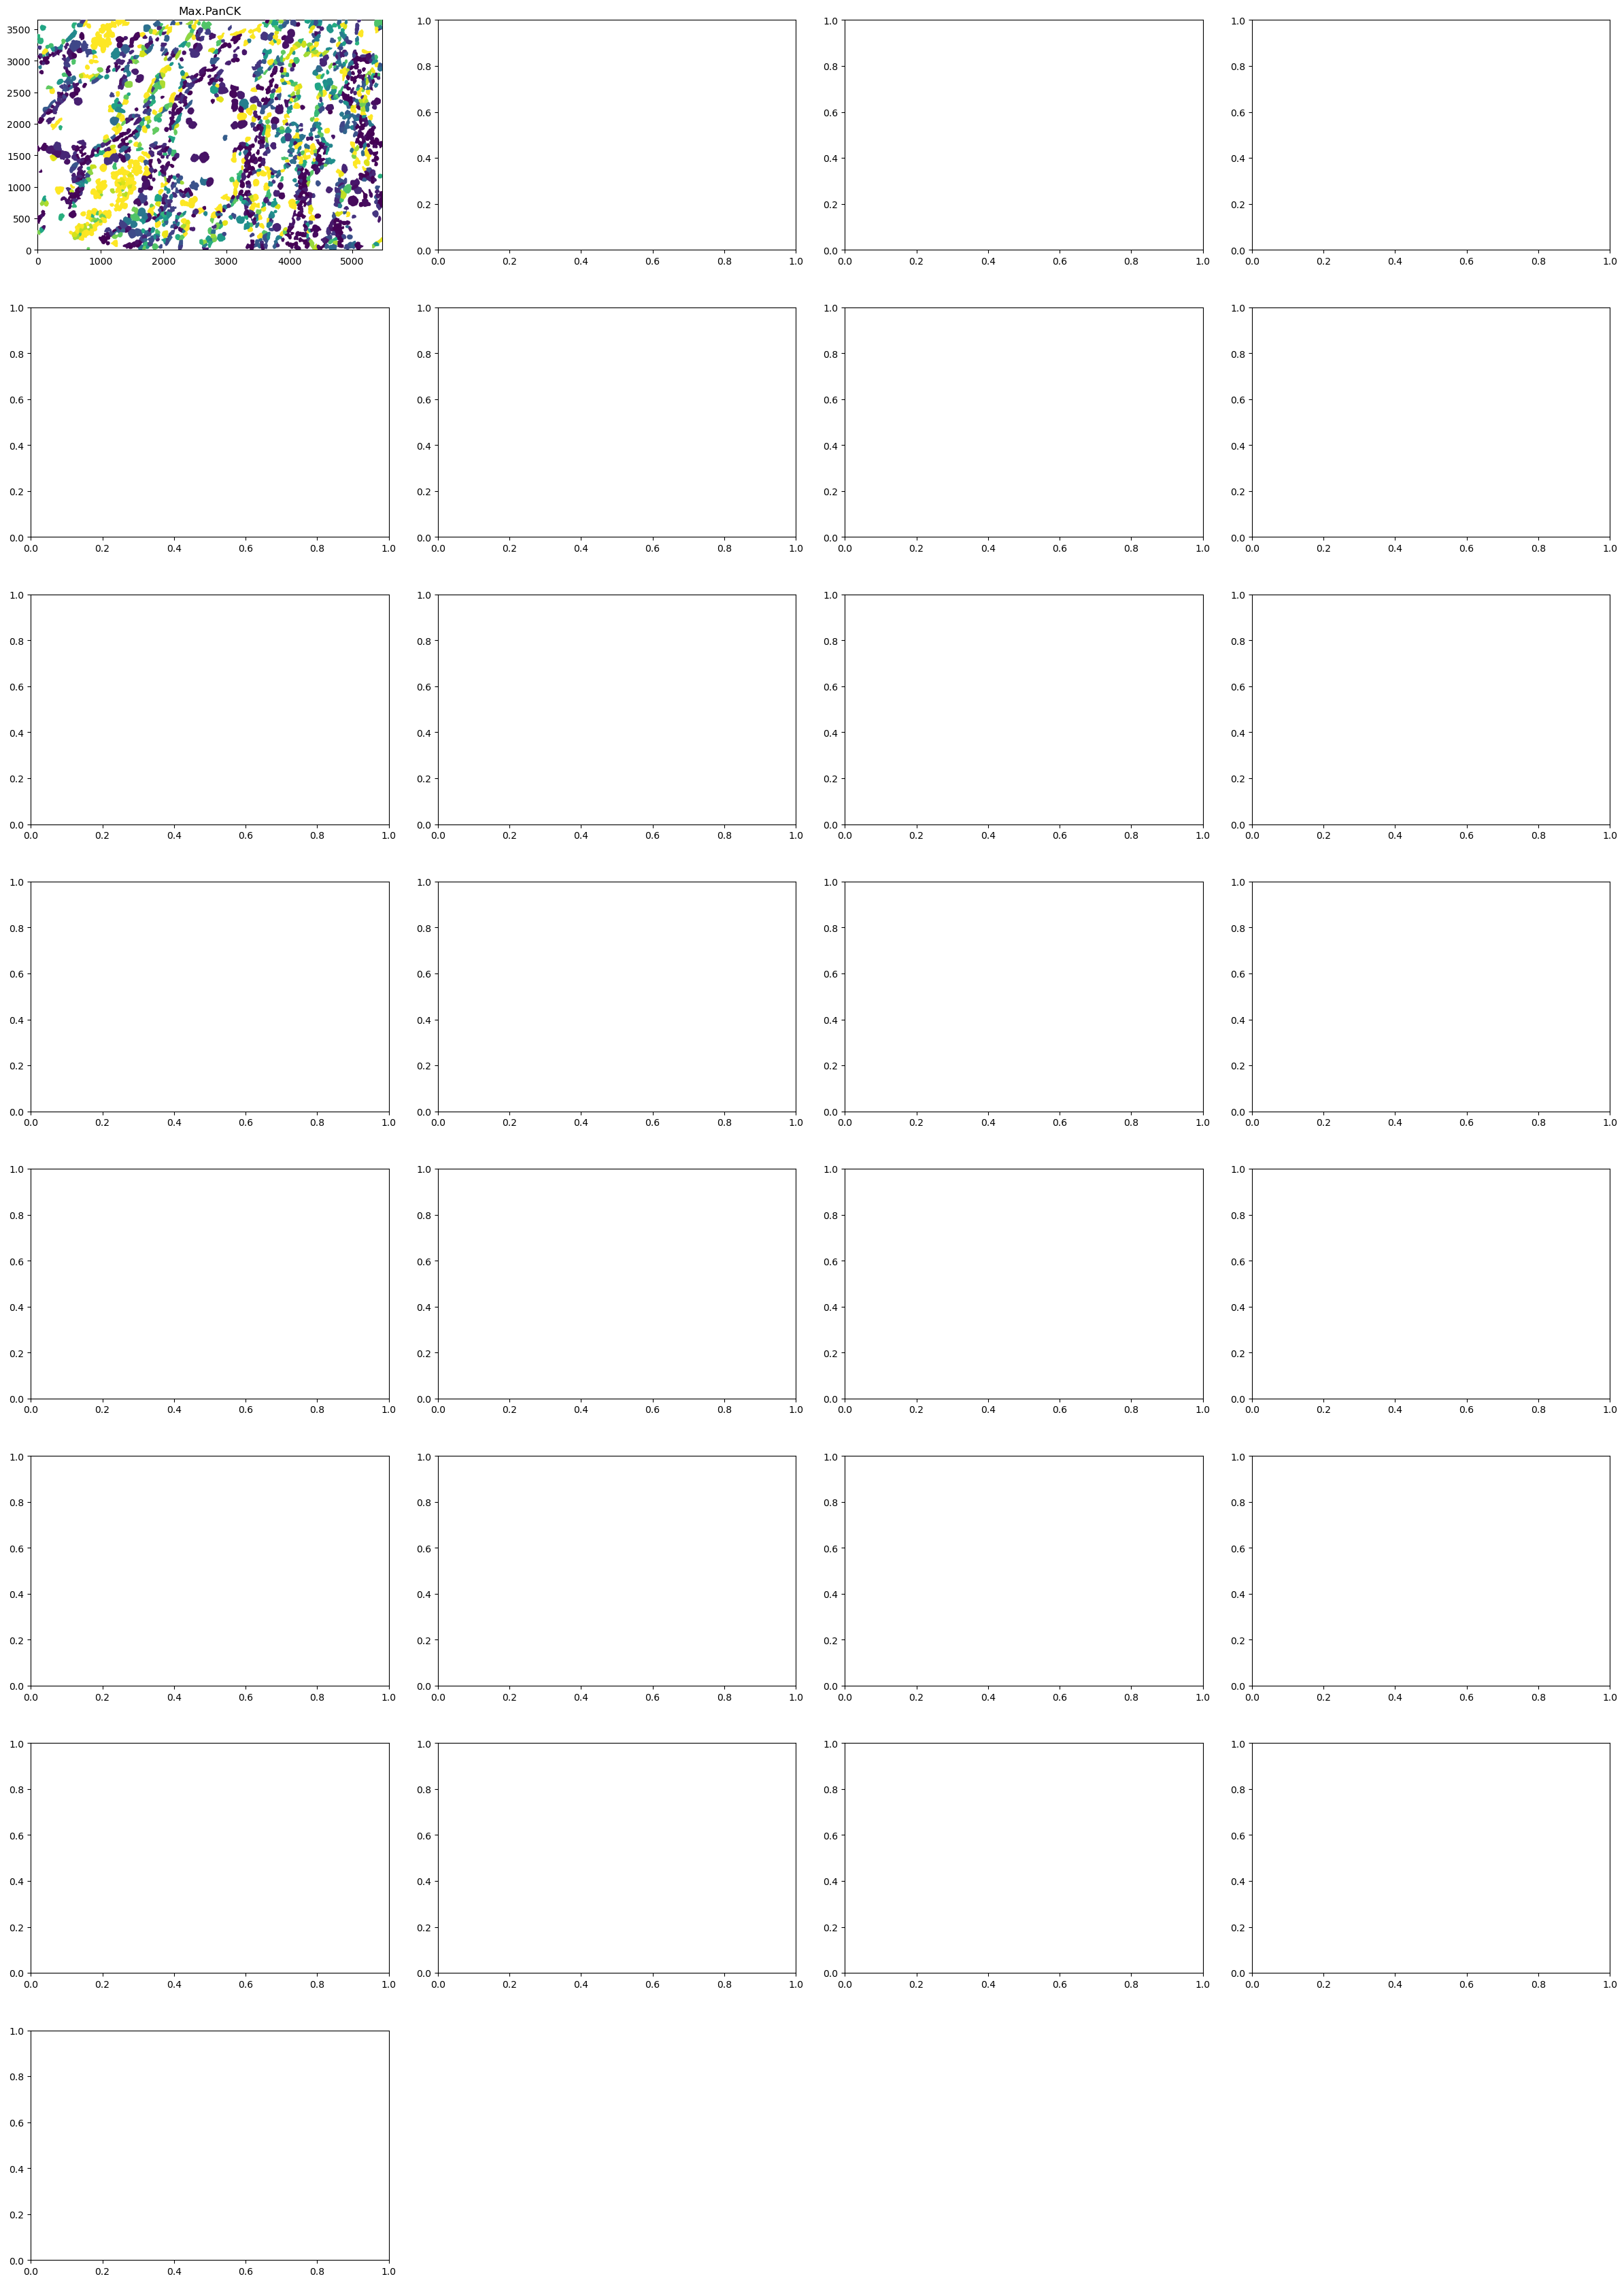

In [40]:
sq.pl.spatial_segment(
    adata,
    color="Max.PanCK",
    library_key="fov",
    seg_cell_id="cell_ID",
)

TypeError: 'collection' must be an instance of matplotlib.collections.Collection, not a matplotlib.image.AxesImage

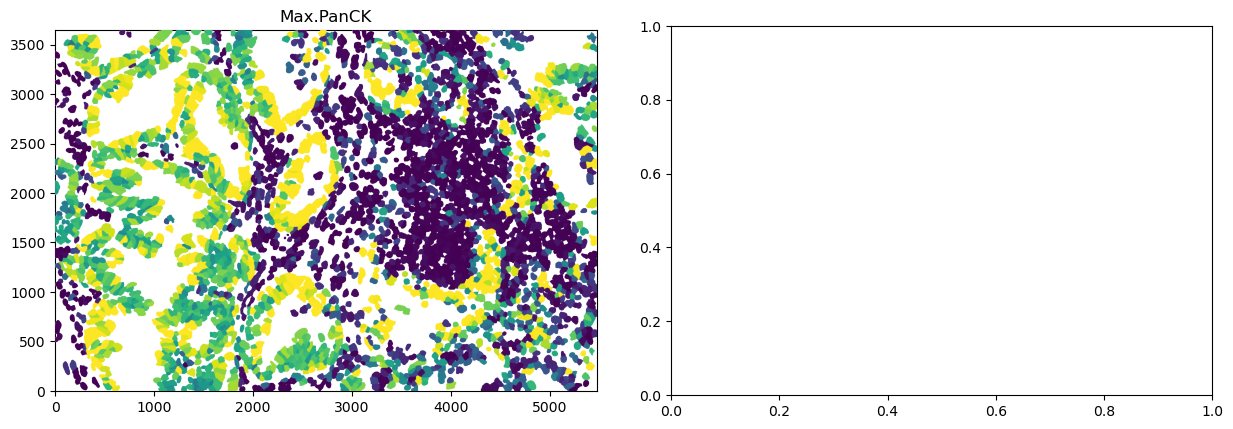

In [41]:
sq.pl.spatial_segment(
    adata,
    color="Max.PanCK",
    library_key="fov",
    library_id=["12", "16"],
    seg_cell_id="cell_ID",
)

TypeError: 'collection' must be an instance of matplotlib.collections.Collection, not a matplotlib.image.AxesImage

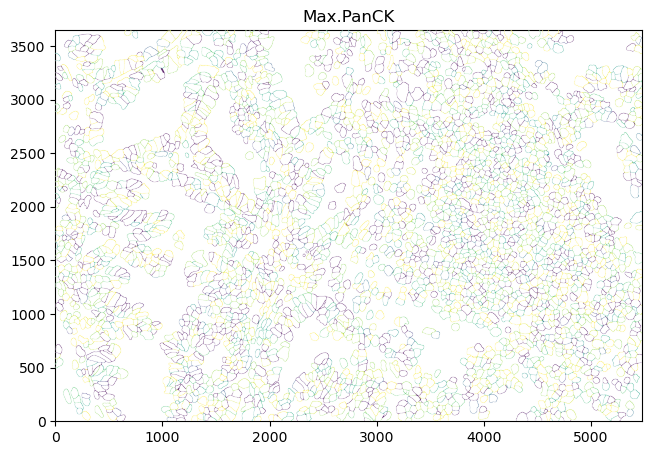

In [42]:
sq.pl.spatial_segment(
    adata,
    color="Max.PanCK",
    library_key="fov",
    library_id="12",
    seg_cell_id="cell_ID",
    seg_contourpx=10,
    crop_coord=[(0, 0, 700, 700)],
)

TypeError: 'collection' must be an instance of matplotlib.collections.Collection, not a matplotlib.image.AxesImage

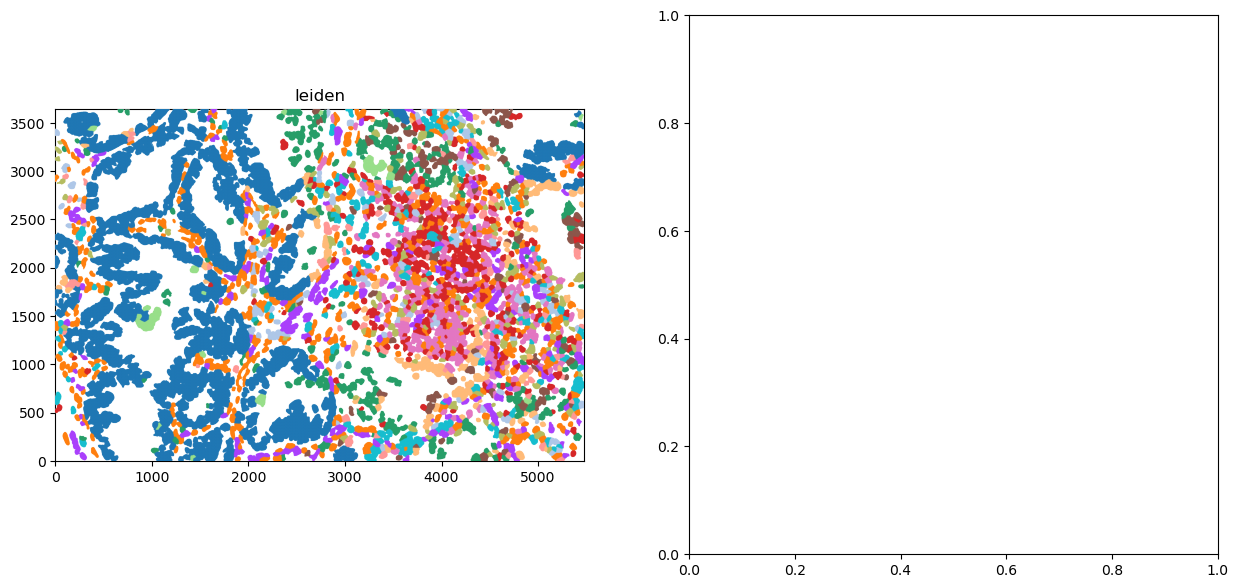

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sq.pl.spatial_segment(
    adata,
    shape="hex",
    color="leiden",
    library_key="fov",
    library_id="12",
    seg_cell_id="cell_ID",
    img=False,
    size=60,
    ax=ax[0],
)

sq.pl.spatial_segment(
    adata,
    color="leiden",
    seg_cell_id="cell_ID",
    library_key="fov",
    library_id="16",
    img=False,
    size=60,
    ax=ax[1],
)